In [310]:
import numpy as np
import pandas as pd
import scipy as sc

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline

In [311]:
data = pd.read_csv('NYPOP.csv')
data['YEAR'] = data['DATE'].apply(lambda x: int(str(x)[:4]))

In [312]:
years = data['YEAR'].values
population_series = data['NYPOP'].values

In [313]:
def plot_series():
    plt.figure(figsize=(14,6))
    plt.xlabel('Year')
    plt.ylabel('Population')
    plt.xlim(1895, 2021)
    plt.ylim(0.95*min(population_series), 1.15*max(population_series))
    plt.plot(years, population_series, lw=1, color='navy', label='Time series');
    plt.plot([2006.5, 2006.5], [0, 10**5], 'k--', lw=1, color='grey');

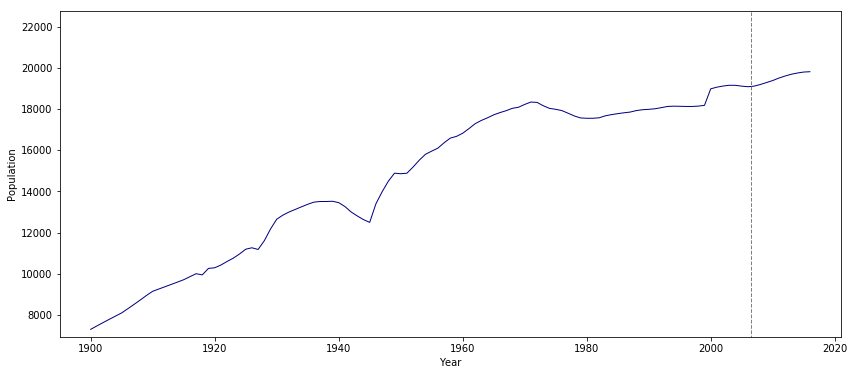

In [314]:
plot_series();

### Общий подход

Из временного ряда отложим последние 10 записей для оценки качества экстраполяции метода.

$A\, c = f$ - исходная переопределенная система

$A^*\,A \, c = A^* \, f$ - каноническая система $\Longleftrightarrow A^T\,A \, c = A^T \, f$, так как $A\in R^{m\times (N+1)}$

Каноническую систему разрешаем относительно $c$, тем самым получаем находим зависимость $f_{ext}=A_{ext} \,c$, где $A_{ext}$ - все записи, включая отложенные, таким образом предсказыжем весь временной ряд. 

## 1. Базис из многочленов вида $x^n$

Отскалируем величины $x$ до отрезка [0,1]. Формально теорема Вейрштрасса о полноте системы $\{1,x,\dots, x^n\}$ выполнена для любого отрезка, значит, данная система ортогональна на отрезке [0,1].

$f(x)=\sum\limits_{n=0}^N c_n\cdot x^n = (1, x, x^2, \dots, x^N) \cdot (c_0, c_1, c_2, \dots, c_N)^T$ - модель


$A=
\begin{pmatrix}
  1& x_1 & \dots & x_1^N \\
  \dots& \dots & \dots & \dots \\
  1& x_m & \dots & x_m^N
\end{pmatrix}
$, где $\{x_i\}_{i=1}^m$ - отскалированные величины годов наблюдения;

In [315]:
def polynomial_approximation(N):
    xs = np.linspace(0,1,len(years))
    A = np.matrix([[x**n for n in range(N+1)] for x in xs[:-10]])
    ext_A = np.matrix([[x**n for n in range(N+1)] for x in xs])
    f = population_series[:-10]
    
    hatA = np.transpose(A) * A
    hatf = np.transpose(A) * np.transpose(np.matrix(f))
    
    coefs = np.linalg.solve(hatA, hatf)
    approx_vals = ext_A * coefs
    return approx_vals

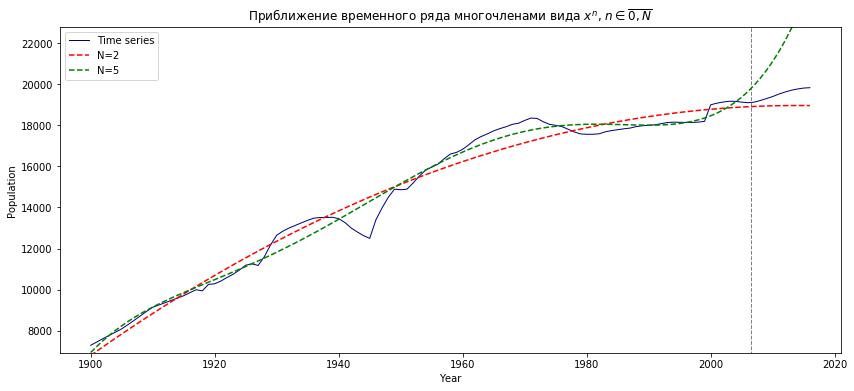

In [320]:
# оси сохранены для наглядности результатов
plot_series();
for N, color in zip([2, 5],['red', 'green']):
    plt.plot(years, polynomial_approximation(N), 'k--', color=color, label='N='+str(N));
plt.title('Приближение временного ряда многочленами вида $x^n$, $n\in \overline{0,N}$')
plt.legend();

### Подбор оптимальных весов

In [317]:
best_params = 4
print(f'Оптимальный параметр: N={best_params}')
print(f'Ошибка на тренировочном периоде при N={best_params}: MSE=%0.3f'
%mean_squared_error(np.transpose(polynomial_approximation(best_params)).tolist()[0][:-10],\
                   population_series[:-10]))
print(f'Ошибка на тренировочном периоде при N=10: MSE=%0.3f'
%mean_squared_error(np.transpose(polynomial_approximation(10)).tolist()[0][:-10],\
                   population_series[:-10]))

Оптимальный параметр: N=4
Ошибка на тренировочном периоде при N=4: MSE=276222.749
Ошибка на тренировочном периоде при N=10: MSE=99588.316


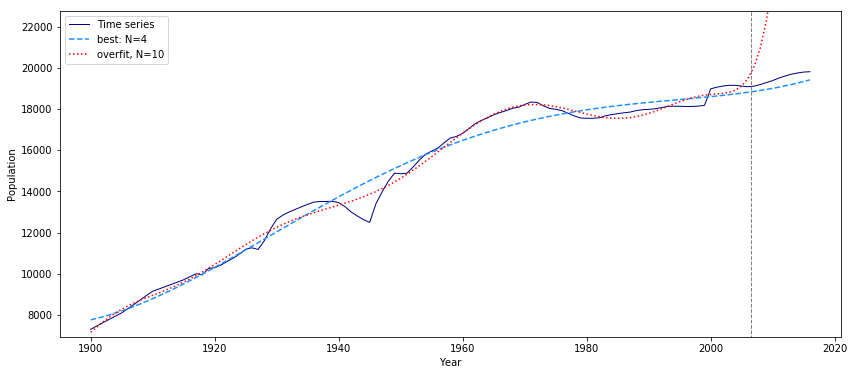

In [322]:
plot_series();
plt.plot(years, polynomial_approximation(best_params), 'k--', color='dodgerblue', label='best: N='+str(best_params));
plt.plot(years, polynomial_approximation(10), 'k:', color='red', label='overfit, N=10');
plt.legend();

Вычислим ошибку прогнозирования будущего. Для этого оценим *MSE* на отложенных данных с 2007 по 2016

In [319]:
print(f'Ошибка прогнозирования при N={best_params}: MSE=%0.3f'
%mean_squared_error(np.transpose(polynomial_approximation(best_params)).tolist()[0][-10:],\
                   population_series[-10:]))
print('Ошибка прогнозирования при N=10: MSE=%0.3f'
%mean_squared_error(np.transpose(polynomial_approximation(10)).tolist()[0][-10:],\
                   population_series[-10:]))

Ошибка прогнозирования при N=4: MSE=169060.205
Ошибка прогнозирования при N=10: MSE=384870503.144


* Отметим, что аппроксимация улучшается с увеличением параметра $N$, но, начиная с некоторого момента, приводит к переобучению. То есть возникает проблема неправильно выделения тренда временного ряда, что в свою очередь ведет к существенной ошибке на отложенных данных.
* При оптимальном параметре $N=4$ ошибка на отложенной выборке сравнима с ошибкой на оптимизационной части ряда. Метод валиден.

## 2. Базис из многочленов Бернштейна

Базисные многочлены Бернштейна степени $N$ образуют базис для линейного пространства многочленов степени $N$. 

Заранее отскалируем данные по годам наблюдения до отрезка [0,1].

$b_{k,n}(x) = C_n^k\cdot x^k\cdot (1-x)^{n-k}$ - базисные многочлены Бернштейна

$f(x) = \sum \limits_{k=0}^{N} c_k \cdot b_{k,N}(x) = (b_{0,N}(x), b_{1,N}(x), \dots, b_{N,N}(x)) \cdot (c_0, c_1, \dots, c_N)^T$ - модель

$A = 
\begin{pmatrix}
  b_{0,N}(x_1)& b_{1,N}(x_1) & \dots & b_{N,N}(x_1) \\
  \dots& \dots & \dots & \dots \\
  b_{0,N}(x_m)& b_{1,N}(x_m) & \dots & b_{N,N}(x_m)
\end{pmatrix}$, где $\{x_i\}_{i=1}^m$ - отскалированные величины годов наблюдения;

In [239]:
# базисные многочлены Бернштейна
def b(k, n, x):
    b = sc.special.binom(n, k) * x**k * (1-x)**(n-k)
    return b

In [240]:
def bernstein_approximation(N):
    A = np.matrix([[b(k, N, x) for k in range(N+1)] for x in range(1, len(years)-9)])
    ext_A = np.matrix([[b(k, N, x) for k in range(N+1)] for x in range(1, len(years)+1)])
    f = population_series[:-10]
    
    hatA = np.transpose(A) * A
    hatf = np.transpose(A) * np.transpose(np.matrix(f))
    
    coefs = np.linalg.solve(hatA, hatf)
    approx_vals = ext_A * coefs
    return approx_vals

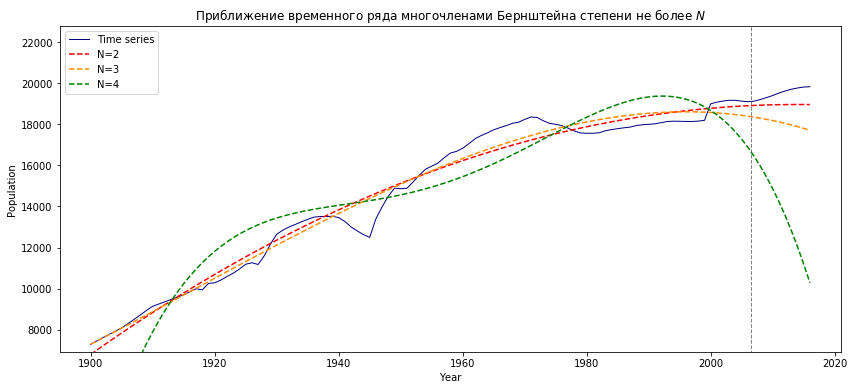

In [247]:
plot_series();
for N, color in zip([2,3,4],['red', 'darkorange', 'green']):
    plt.plot(years, bernstein_approximation(N), 'k--', color=color, label='N='+str(N));
plt.title('Приближение временного ряда многочленами Бернштейна степени не более $N$');
plt.legend();

Как видим, при $N\ge3$ аппроксимация становится неудачной из-за потери тренда роста рассматриваемой величины. 

In [280]:
best_params = 2
print(f'Оптимальный параметр: N={best_params}')
print('Ошибка на тренировочном периоде: MSE=%0.3f'
%mean_squared_error(np.transpose(bernstein_approximation(best_params)).tolist()[0][:-10],\
                   population_series[:-10]))

Оптимальный параметр: N=2
Ошибка на тренировочном периоде: MSE=344556.585


Вычислим ошибку прогнозирования будущего. Для этого оценим *MSE* на отложенных данных с 2007 по 2016

In [281]:
print('Ошибка прогнозирования: MSE=%0.3f'
%mean_squared_error(np.transpose(bernstein_approximation(best_params)).tolist()[0][-10:],\
                   population_series[-10:]))

Ошибка прогнозирования: MSE=389637.358


Ошибка на отложенной выборке сравнима с ошибкой на оптимизационной части ряда. Метод валиден.

## 3. Базис из многочленов Чебышёва

$T_0(x) = 1, \, T_1(x)=x, \, T_{n+1}(x) = 2x\cdot T_n(x) - T_{n-1}(x)$ - многочлены 1-ого рода;

$U_0(x) = 1, \, U_1(x)=2x, \, U_{n+1}(x) = 2x\cdot U_n(x) - U_{n-1}(x)$ - многочлены 2-ого рода;

* $f(x) = \sum \limits_{k=0}^{N} c_k \cdot T_k(x) = (T_0(x), T_1(x), \dots, T_N(x)) \cdot (c_0, c_1, \dots, c_N)^T$ - модель 1
* $f(x) = \sum \limits_{k=0}^{N} c_k \cdot U_k(x) = (U_0(x), U_1(x), \dots, U_N(x)) \cdot (c_0, c_1, \dots, c_N)^T$ - модель 2

$A_1 = 
\begin{pmatrix}
  T_0(x_1)& T_1(x_1) & \dots & T_N(x_1) \\
  \dots& \dots & \dots & \dots \\
  T_0(x_m)& T_1(x_m) & \dots & T_N(x_m)
\end{pmatrix}$, где $\{x_i\}_{i=1}^m$ - отскалированные величины годов наблюдения;

$A_2 = 
\begin{pmatrix}
  U_0(x_1)& U_1(x_1) & \dots & U_N(x_1) \\
  \dots& \dots & \dots & \dots \\
  U_0(x_m)& U_1(x_m) & \dots & U_N(x_m)
\end{pmatrix}$, где $\{x_i\}_{i=1}^m$ - отскалированные величины годов наблюдения;

Заранее отскалируем ось $x$ до области ортогональности многочленов Чебышева, то есть отрезка [-1,1].

In [252]:
# многочлены Чебышева
def T(N,x):
    Tpp, Tp = 1, x
    Ts = [Tpp, Tp]
    for i in range(2, N):
        T = 2*x*Tp - Tpp
        Ts.append(T)
        Tp, Tpp = T, Tp
    return Ts

def U(N,x):
    Tpp, Tp = 1, 2*x
    Ts = [Tpp, Tp]
    for i in range(2, N):
        T = 2*x*Tp - Tpp
        Ts.append(T)
        Tp, Tpp = T, Tp
    return Ts

In [253]:
def chebyshev_approximation(N, func):
    xs = np.linspace(-1,1,len(years))
    A = np.matrix([func(N,x) for x in xs[:-10]])
    ext_A = np.matrix([func(N,x) for x in xs])
    f = population_series[:-10]
    
    hatA = np.transpose(A) * A
    hatf = np.transpose(A) * np.transpose(np.matrix(f))
    
    coefs = np.linalg.solve(hatA, hatf)
    approx_vals = ext_A * coefs
    return approx_vals

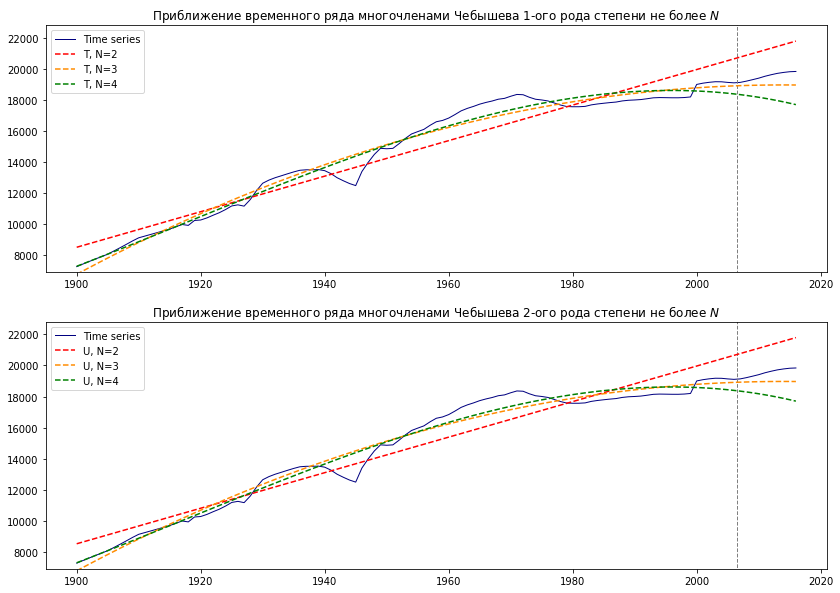

In [254]:
plt.figure(figsize=(14,10))

plt.subplot(211)
plt.xlim(1895, 2021)
plt.ylim(0.95*min(population_series), 1.15*max(population_series))
plt.plot(years, population_series, lw=1, color='navy', label='Time series');
plt.plot([2006.5, 2006.5], [0, 10**5], 'k--', lw=1, color='grey');
for N, color in zip([2,3,4],['red', 'darkorange', 'green']):
    plt.plot(years, chebyshev_approximation(N, T), 'k--', color=color, label='T, N='+str(N));
plt.legend();
plt.title('Приближение временного ряда многочленами Чебышева 1-ого рода степени не более $N$');

plt.subplot(212)
plt.xlim(1895, 2021)
plt.ylim(0.95*min(population_series), 1.15*max(population_series))
plt.plot(years, population_series, lw=1, color='navy', label='Time series');
plt.plot([2006.5, 2006.5], [0, 10**5], 'k--', lw=1, color='grey');
for N, color in zip([2,3,4],['red', 'darkorange', 'green']):
    plt.plot(years, chebyshev_approximation(N, U), 'k--', color=color, label='U, N='+str(N));
plt.legend();
plt.title('Приближение временного ряда многочленами Чебышева 2-ого рода степени не более $N$');

Как можно заметить из инфографики, приближения эквивалентны. 

### Подбор оптимальных параметров

In [271]:
best_params_T = 3
print(f'Оптимальный параметр для 1-ого рода: N={best_params_T}')
print(f'Ошибка на тренировочном периоде N={best_params_T}: MSE=%0.3f'
%mean_squared_error(np.transpose(chebyshev_approximation(best_params_T, T)).tolist()[0][:-10],\
                   population_series[:-10]))
print('Ошибка на тренировочном периоде N=10: MSE=%0.3f'
%mean_squared_error(np.transpose(chebyshev_approximation(10, T)).tolist()[0][:-10],\
                   population_series[:-10]))

Оптимальный параметр для 1-ого рода: N=3
Ошибка на тренировочном периоде N=3: MSE=344556.585
Ошибка на тренировочном периоде N=10: MSE=112245.036


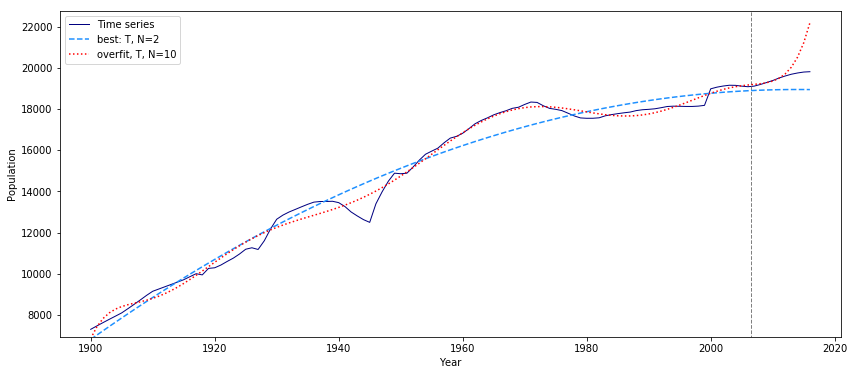

In [285]:
plot_series();
plt.plot(years, chebyshev_approximation(best_params_T, T), 'k--', color='dodgerblue', label='best: T, N='+str(best_params));
plt.plot(years, chebyshev_approximation(10, T), 'k:', color='red', label='overfit, T, N=10');
plt.legend();

Отметим, что тут имеет место проблема потери тренда и переобучения, начиная с $N=4$.

Вычислим ошибку прогнозирования будущего. Для этого оценим MSE на отложенных данных с 2007 по 2016

In [289]:
print('Ошибка прогнозирования N=2: MSE=%0.3f'
%mean_squared_error(np.transpose(chebyshev_approximation(best_params_T, T)).tolist()[0][-10:],\
                   population_series[-10:]))
print('Ошибка прогнозирования N=10: MSE=%0.3f'
%mean_squared_error(np.transpose(chebyshev_approximation(10, T)).tolist()[0][-10:],\
                   population_series[-10:]))

Ошибка прогнозирования N=2: MSE=389637.389
Ошибка прогнозирования N=10: MSE=842004.281


Ошибка на отложенной выборке сравнима с ошибкой на оптимизационной части ряда. Метод валиден.